## Creating a notebook to classify the outcome of a football game using KNN and logistic regression.

The outcome of the football match can be either out of the 3 classifications:
- 0:The match is a draw
- 1:The match is won by the Home Team
- 2: The match is won by the Away Team

The dataset to build the model was downloaded from : https://www.kaggle.com/datasets/davidcariboo/player-scores/. The model was built on the dataset 'games.csv'

### Importing required packages

In [119]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold

### Importing and visualising the data

In [2]:
df = pd.read_csv('games.csv')
df.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type
0,2222597,RU1,2012,6. Matchday,2012-08-25,3725,232,2.0,1.0,2.0,...,Akhmat-Arena,21700.0,Vladislav Bezborodov,https://www.transfermarkt.co.uk/terek-grozny_s...,NaN,NaN,Akhmat Grozny,Spartak Moscow,2:1,domestic_league
1,2222627,RU1,2012,5. Matchday,2012-08-20,2696,4128,0.0,2.0,11.0,...,Metallurg,11400.0,Sergey Ivanov,https://www.transfermarkt.co.uk/krylya-sovetov...,NaN,NaN,Krylya Sovetov Samara,Amkar Perm,0:2,domestic_league
2,2222658,RU1,2012,10. Matchday,2012-09-30,2410,121,0.0,2.0,2.0,...,Arena Khimki,12000.0,Sergey Karasev,https://www.transfermarkt.co.uk/cska-moscow_di...,NaN,NaN,CSKA Moscow,Dynamo Moscow,0:2,domestic_league
3,2222664,RU1,2012,8. Matchday,2012-09-15,932,2698,1.0,0.0,5.0,...,RZD Arena,11408.0,Sergey Karasev,https://www.transfermarkt.co.uk/lokomotiv-mosc...,NaN,NaN,Lokomotiv Moscow,Rubin Kazan,1:0,domestic_league
4,2222683,RU1,2012,12. Matchday,2012-10-22,2696,12438,0.0,1.0,11.0,...,Metallurg,7534.0,Timur Arslanbekov,https://www.transfermarkt.co.uk/krylya-sovetov...,NaN,NaN,Krylya Sovetov Samara,Volga Nizhniy Novgorod (- 2016),0:1,domestic_league


In [3]:
df.shape

(64273, 23)

Adding a column 'Outcome' based on the scores which becomes the target column for our model


In [4]:
conditions=[df['home_club_goals'] == df['away_club_goals'],df['home_club_goals'] > df['away_club_goals'],df['home_club_goals'] < df['away_club_goals']] 
values=[0, 1, 2] 
df['Outcome']=np.select(conditions,values)

## Checking and cleaning data

In [6]:
df.duplicated().any()

False

In [7]:
df = df.drop('home_club_formation', axis=1)

In [8]:
df = df.drop('away_club_formation', axis=1)

In [9]:
df = df.drop('url', axis=1)

Checking for columns with 'NaN' values

In [10]:
df.isna().any()

game_id                   False
competition_id            False
season                    False
round                     False
date                      False
home_club_id              False
away_club_id              False
home_club_goals            True
away_club_goals            True
home_club_position         True
away_club_position         True
home_club_manager_name     True
away_club_manager_name     True
stadium                    True
attendance                 True
referee                    True
home_club_name             True
away_club_name             True
aggregate                  True
competition_type          False
Outcome                   False
dtype: bool

Removing columns with 'NaN' values that are not imputable

In [11]:
na_columns = ['home_club_name', 'away_club_name', 'referee','stadium','home_club_manager_name','away_club_manager_name']

In [12]:
df = df.dropna(subset=na_columns)

Imputing the 'NaN' attendance values with the respective stadiums mean attendance value

In [13]:
grouped_df = df.groupby('stadium')
mean_attendance = grouped_df['attendance'].transform('mean')
df['attendance'].fillna(mean_attendance, inplace=True)

In [14]:
filtered_df = df[df['attendance'].isnull()]
filtered_df.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_name,away_club_name,aggregate,competition_type,Outcome
2817,3909960,UKR1,2022,6. Matchday,2022-10-07,26459,83678,1.0,2.0,5.0,...,Yuriy Virt,Oleg Ratiy,Stadion Avangard (2022),NaN,Viktor Kopiyevskyi,NK Veres Rivne,Metalist Kharkiv,1:2,domestic_league,2
3055,3412696,EL,2019,Quarter-Finals,2020-08-11,543,368,0.0,1.0,NaN,...,Nuno Espírito Santo,Julen Lopetegui,MSV-Arena,NaN,Daniele Orsato,Wolverhampton Wanderers,Sevilla FC,0:1,international_cup,2
3266,3426852,TR1,2020,7. Matchday,2020-11-02,7775,2381,1.0,1.0,5.0,...,Ömer Erdogan,Riza Calimbay,Antakya Atatürk Stadı,NaN,Yasin Kol,Hatayspor,Sivasspor,1:1,domestic_league,0
3270,3426985,TR1,2020,20. Matchday,2021-01-20,7775,19789,1.0,2.0,6.0,...,Ömer Erdogan,Hamza Hamzaoglu,Antakya Atatürk Stadı,NaN,Ramazan Keles,Hatayspor,Yeni Malatyaspor,1:2,domestic_league,2
3271,3427073,TR1,2020,29. Matchday,2021-03-07,7775,3205,1.0,3.0,6.0,...,Ömer Erdogan,Ugur Kulaksiz,Antakya Atatürk Stadı,NaN,Yasar Kemal Ugurlu,Hatayspor,Kayserispor,1:3,domestic_league,2


In [15]:
df[df['attendance'].isna()]

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_name,away_club_name,aggregate,competition_type,Outcome
2817,3909960,UKR1,2022,6. Matchday,2022-10-07,26459,83678,1.0,2.0,5.0,...,Yuriy Virt,Oleg Ratiy,Stadion Avangard (2022),NaN,Viktor Kopiyevskyi,NK Veres Rivne,Metalist Kharkiv,1:2,domestic_league,2
3055,3412696,EL,2019,Quarter-Finals,2020-08-11,543,368,0.0,1.0,NaN,...,Nuno Espírito Santo,Julen Lopetegui,MSV-Arena,NaN,Daniele Orsato,Wolverhampton Wanderers,Sevilla FC,0:1,international_cup,2
3266,3426852,TR1,2020,7. Matchday,2020-11-02,7775,2381,1.0,1.0,5.0,...,Ömer Erdogan,Riza Calimbay,Antakya Atatürk Stadı,NaN,Yasin Kol,Hatayspor,Sivasspor,1:1,domestic_league,0
3270,3426985,TR1,2020,20. Matchday,2021-01-20,7775,19789,1.0,2.0,6.0,...,Ömer Erdogan,Hamza Hamzaoglu,Antakya Atatürk Stadı,NaN,Ramazan Keles,Hatayspor,Yeni Malatyaspor,1:2,domestic_league,2
3271,3427073,TR1,2020,29. Matchday,2021-03-07,7775,3205,1.0,3.0,6.0,...,Ömer Erdogan,Ugur Kulaksiz,Antakya Atatürk Stadı,NaN,Yasar Kemal Ugurlu,Hatayspor,Kayserispor,1:3,domestic_league,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62489,4120577,UKR1,2023,2. Matchday,2023-08-05,61825,63007,0.0,3.0,16.0,...,Volodymyr Sharan,Oleksandr Kovpak,Minaj-Arena,NaN,Roman Blavatskyi,FK Minaj,LNZ Cherkasy,0:3,domestic_league,2
62541,4170606,UKRP,2023,Round of 16,2023-09-27,55686,2740,0.0,3.0,NaN,...,Edmar Galovskyi,Viktor Skrypnyk,Livyi Bereg Arena,NaN,Denys Reznikov,Metalist 1925 Kharkiv,Vorskla Poltava,0:3,domestic_cup,2
62559,4162173,ECLQ,2023,Qualifying Round 1st leg,2023-08-24,338,114,2.0,3.0,NaN,...,Mircea Lucescu,Senol Günes,Giuleşti - Valentin Stănescu,NaN,Darren England,Dynamo Kyiv,Besiktas JK,2:3,international_cup,2
62572,4066671,UKR1,2022,28. Matchday,2023-05-25,18105,6992,0.0,1.0,16.0,...,Anatoliy Bezsmertnyi,Roman Grygorchuk,Stadion SKIF,NaN,Anastasiya Romanyuk,PFK Lviv,Chornomorets Odessa,0:1,domestic_league,2


In [16]:
df[df['stadium'] == 'MSV-Arena']

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_name,away_club_name,aggregate,competition_type,Outcome
3055,3412696,EL,2019,Quarter-Finals,2020-08-11,543,368,0.0,1.0,NaN,...,Nuno Espírito Santo,Julen Lopetegui,MSV-Arena,NaN,Daniele Orsato,Wolverhampton Wanderers,Sevilla FC,0:1,international_cup,2
37277,3328537,EL,2019,Round of 16,2020-08-06,368,12,2.0,0.0,NaN,...,Julen Lopetegui,Paulo Fonseca,MSV-Arena,NaN,Björn Kuipers,Sevilla FC,AS Roma,2:0,international_cup,1


In [17]:
df[df['stadium'] == 'Livyi Bereg Arena']

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_name,away_club_name,aggregate,competition_type,Outcome
26196,4120625,UKR1,2023,8. Matchday,2023-09-24,55686,48332,0.0,0.0,7.0,...,Edmar Galovskyi,Yaroslav Vyshnyak,Livyi Bereg Arena,NaN,Mykhaylo Rayda,Metalist 1925 Kharkiv,Kolos Kovalivka,0:0,domestic_league,0
52942,4120629,UKR1,2023,8. Matchday,2023-09-24,10690,60551,0.0,1.0,14.0,...,Valeriy Kryventsov,Yuriy Maksymov,Livyi Bereg Arena,NaN,Kateryna Monzul,Zorya Lugansk,SK Dnipro-1,0:1,domestic_league,2
54872,4120596,UKR1,2023,4. Matchday,2023-08-18,10690,18303,0.0,0.0,10.0,...,Nenad Lalatovic,Ruslan Rotan,Livyi Bereg Arena,NaN,Yuriy Ivanov,Zorya Lugansk,FK Oleksandriya,0:0,domestic_league,0
60573,4120593,UKR1,2023,4. Matchday,2023-08-19,55686,61825,1.0,0.0,12.0,...,Edmar Galovskyi,Volodymyr Sharan,Livyi Bereg Arena,NaN,Klym Zabroda,Metalist 1925 Kharkiv,FK Minaj,1:0,domestic_league,1
62472,4104305,UKR1,2023,1. Matchday,2023-07-29,55686,660,1.0,2.0,12.0,...,Edmar Galovskyi,Patrick van Leeuwen,Livyi Bereg Arena,NaN,Vitaliy Romanov,Metalist 1925 Kharkiv,Shakhtar Donetsk,1:2,domestic_league,2
62488,4120620,UKR1,2023,7. Matchday,2023-09-15,55686,10690,2.0,1.0,6.0,...,Edmar Galovskyi,Valeriy Kryventsov,Livyi Bereg Arena,NaN,Klym Zabroda,Metalist 1925 Kharkiv,Zorya Lugansk,2:1,domestic_league,1
62541,4170606,UKRP,2023,Round of 16,2023-09-27,55686,2740,0.0,3.0,NaN,...,Edmar Galovskyi,Viktor Skrypnyk,Livyi Bereg Arena,NaN,Denys Reznikov,Metalist 1925 Kharkiv,Vorskla Poltava,0:3,domestic_cup,2


Drooping all other 'NaN' values rows that were not imputable as mean could not be calculated.

In [18]:
na_attendance = ['attendance']
df.dropna(subset=na_attendance, inplace=True)

In [19]:
df.isna().any()

game_id                   False
competition_id            False
season                    False
round                     False
date                      False
home_club_id              False
away_club_id              False
home_club_goals           False
away_club_goals           False
home_club_position         True
away_club_position         True
home_club_manager_name    False
away_club_manager_name    False
stadium                   False
attendance                False
referee                   False
home_club_name            False
away_club_name            False
aggregate                 False
competition_type          False
Outcome                   False
dtype: bool

Filling 'NaN' values of 'home_club_position' and 'away_club_position' with the clubs respective mode.

In [81]:
home_club_modes = df.groupby('home_club_id')['home_club_position'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['home_club_position'] = df.apply(lambda row: away_club_modes[row['home_club_id']] if pd.isna(row['home_club_position']) else row['home_club_position'], axis=1)

In [22]:
away_club_modes = df.groupby('away_club_id')['away_club_position'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['away_club_position'] = df.apply(lambda row: away_club_modes[row['away_club_id']] if pd.isna(row['away_club_position']) else row['away_club_position'], axis=1)

In [82]:
df.isna().any()

game_id               False
season                False
home_club_id          False
away_club_id          False
home_club_position    False
away_club_position    False
attendance            False
Outcome               False
home_manager_id       False
away_manager_id       False
stadium_id            False
dtype: bool

In [24]:
df.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_name,away_club_name,aggregate,competition_type,Outcome
0,2222597,RU1,2012,6. Matchday,2012-08-25,3725,232,2.0,1.0,2.0,...,Stanislav Cherchesov,Unai Emery,Akhmat-Arena,21700.0,Vladislav Bezborodov,Akhmat Grozny,Spartak Moscow,2:1,domestic_league,1
1,2222627,RU1,2012,5. Matchday,2012-08-20,2696,4128,0.0,2.0,11.0,...,Andrey Kobelev,Rustem Khuzin,Metallurg,11400.0,Sergey Ivanov,Krylya Sovetov Samara,Amkar Perm,0:2,domestic_league,2
2,2222658,RU1,2012,10. Matchday,2012-09-30,2410,121,0.0,2.0,2.0,...,Leonid Slutski,Dan Petrescu,Arena Khimki,12000.0,Sergey Karasev,CSKA Moscow,Dynamo Moscow,0:2,domestic_league,2
3,2222664,RU1,2012,8. Matchday,2012-09-15,932,2698,1.0,0.0,5.0,...,Slaven Bilic,Kurban Berdyev,RZD Arena,11408.0,Sergey Karasev,Lokomotiv Moscow,Rubin Kazan,1:0,domestic_league,1
4,2222683,RU1,2012,12. Matchday,2012-10-22,2696,12438,0.0,1.0,11.0,...,Andrey Kobelev,Gadzhi Gadzhiev,Metallurg,7534.0,Timur Arslanbekov,Krylya Sovetov Samara,Volga Nizhniy Novgorod (- 2016),0:1,domestic_league,2


Dropping names of the home and away club because they have already been encoded as 'home_club_id' and 'away_club_id'

In [25]:
df.drop('home_club_name', axis = 1, inplace=True)

In [26]:
df.drop('away_club_name', axis = 1, inplace = True)

Dropping columns that do not relate to the model we are building. The columns 'home_club_goals','away_club_goals','aggregate' have no purpose while builidng our model as we are trying to predict the outcome of the match before it has happened. Thus we remove those columns as well

In [28]:
df.drop('referee', axis = 1, inplace = True)

In [29]:
df.drop('round', axis = 1, inplace = True)

In [30]:
df.drop('home_club_goals', axis = 1, inplace = True)

In [31]:
df.drop('away_club_goals', axis = 1, inplace =True)

In [32]:
df.drop('aggregate', axis = 1, inplace = True)

In [33]:
df.drop('competition_id', axis = 1, inplace =True)

In [34]:
df.drop('competition_type', axis = 1, inplace = True )

In [35]:
df

,game_id,season,date,home_club_id,away_club_id,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,Outcome
0,2222597,2012,2012-08-25,3725,232,2.0,5.0,Stanislav Cherchesov,Unai Emery,Akhmat-Arena,21700.0,1
1,2222627,2012,2012-08-20,2696,4128,11.0,10.0,Andrey Kobelev,Rustem Khuzin,Metallurg,11400.0,2
2,2222658,2012,2012-09-30,2410,121,2.0,13.0,Leonid Slutski,Dan Petrescu,Arena Khimki,12000.0,2
3,2222664,2012,2012-09-15,932,2698,5.0,8.0,Slaven Bilic,Kurban Berdyev,RZD Arena,11408.0,1
4,2222683,2012,2012-10-22,2696,12438,11.0,16.0,Andrey Kobelev,Gadzhi Gadzhiev,Metallurg,7534.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
64222,3852607,2022,2022-10-30,383,467,2.0,15.0,Ruud van Nistelrooy,Rogier Meijer,Philips Stadion,31007.0,1
64223,2589097,2015,2016-02-14,467,383,8.0,1.0,Ernest Faber,Phillip Cocu,Goffertstadion,12353.0,2
64224,2700827,2016,2017-02-18,383,467,3.0,12.0,Phillip Cocu,Peter Hyballa,Philips Stadion,33500.0,1
64225,3852741,2022,2023-04-01,467,383,10.0,3.0,Rogier Meijer,Ruud van Nistelrooy,Goffertstadion,12500.0,2


Encoding columns 'home_club_manager_name' and 'away_club_manager_name' as our model cannot be trained using objects

In [36]:
new_column = pd.concat([df['home_club_manager_name'], df['away_club_manager_name']], ignore_index=True)
new_df = pd.DataFrame({'manager_name': new_column})

In [37]:
new_df

,manager_name
0,Stanislav Cherchesov
1,Andrey Kobelev
2,Leonid Slutski
3,Slaven Bilic
4,Andrey Kobelev
...,...
100927,Rogier Meijer
100928,Phillip Cocu
100929,Peter Hyballa
100930,Ruud van Nistelrooy


In [38]:
new_df = new_df.drop_duplicates()

In [39]:
new_df

,manager_name
0,Stanislav Cherchesov
1,Andrey Kobelev
2,Leonid Slutski
3,Slaven Bilic
5,Kurban Berdyev
...,...
99306,Jens Rasiejewski
99903,Leam Richardson
100622,Domenico Toscano
100749,Stephan Schmidt


In [40]:
ord_enc = OrdinalEncoder()
new_df["manager_code"] = ord_enc.fit_transform(new_df[["manager_name"]])

C:\Users\abina\AppData\Local\Temp\ipykernel_20816\3600308452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["manager_code"] = ord_enc.fit_transform(new_df[["manager_name"]])


In [41]:
new_df

,manager_name,manager_code
0,Stanislav Cherchesov,1643.0
1,Andrey Kobelev,114.0
2,Leonid Slutski,962.0
3,Slaven Bilic,1632.0
5,Kurban Berdyev,930.0
...,...,...
99306,Jens Rasiejewski,776.0
99903,Leam Richardson,945.0
100622,Domenico Toscano,394.0
100749,Stephan Schmidt,1663.0


In [43]:
new_df_result = df.copy()

In [44]:
new_df_result = new_df_result.merge(new_df, left_on='home_club_manager_name', right_on='manager_name', how='left')
new_df_result = new_df_result.rename(columns={'manager_id': 'home_club_manager_id'})
new_df_result = new_df_result.drop(columns=['manager_name'])


new_df_result = new_df_result.merge(new_df, left_on='away_club_manager_name', right_on='manager_name', how='left')
new_df_result = new_df_result.rename(columns={'manager_id': 'away_club_manager_id'})
new_df_result = new_df_result.drop(columns=['manager_name'])

In [45]:
new_df_result

,game_id,season,date,home_club_id,away_club_id,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,Outcome,manager_code_x,manager_code_y
0,2222597,2012,2012-08-25,3725,232,2.0,5.0,Stanislav Cherchesov,Unai Emery,Akhmat-Arena,21700.0,1,1643.0,1770.0
1,2222627,2012,2012-08-20,2696,4128,11.0,10.0,Andrey Kobelev,Rustem Khuzin,Metallurg,11400.0,2,114.0,1539.0
2,2222658,2012,2012-09-30,2410,121,2.0,13.0,Leonid Slutski,Dan Petrescu,Arena Khimki,12000.0,2,962.0,304.0
3,2222664,2012,2012-09-15,932,2698,5.0,8.0,Slaven Bilic,Kurban Berdyev,RZD Arena,11408.0,1,1632.0,930.0
4,2222683,2012,2012-10-22,2696,12438,11.0,16.0,Andrey Kobelev,Gadzhi Gadzhiev,Metallurg,7534.0,2,114.0,543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50461,3852607,2022,2022-10-30,383,467,2.0,15.0,Ruud van Nistelrooy,Rogier Meijer,Philips Stadion,31007.0,1,1541.0,1499.0
50462,2589097,2015,2016-02-14,467,383,8.0,1.0,Ernest Faber,Phillip Cocu,Goffertstadion,12353.0,2,445.0,1417.0
50463,2700827,2016,2017-02-18,383,467,3.0,12.0,Phillip Cocu,Peter Hyballa,Philips Stadion,33500.0,1,1417.0,1402.0
50464,3852741,2022,2023-04-01,467,383,10.0,3.0,Rogier Meijer,Ruud van Nistelrooy,Goffertstadion,12500.0,2,1499.0,1541.0


In [46]:
df = new_df_result

In [47]:
df = df.rename(columns={'manager_code_x': 'home_manager_id'})

In [48]:
df = df.rename(columns={'manager_code_y': 'away_manager_id'})

In [49]:
df

,game_id,season,date,home_club_id,away_club_id,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,Outcome,home_manager_id,away_manager_id
0,2222597,2012,2012-08-25,3725,232,2.0,5.0,Stanislav Cherchesov,Unai Emery,Akhmat-Arena,21700.0,1,1643.0,1770.0
1,2222627,2012,2012-08-20,2696,4128,11.0,10.0,Andrey Kobelev,Rustem Khuzin,Metallurg,11400.0,2,114.0,1539.0
2,2222658,2012,2012-09-30,2410,121,2.0,13.0,Leonid Slutski,Dan Petrescu,Arena Khimki,12000.0,2,962.0,304.0
3,2222664,2012,2012-09-15,932,2698,5.0,8.0,Slaven Bilic,Kurban Berdyev,RZD Arena,11408.0,1,1632.0,930.0
4,2222683,2012,2012-10-22,2696,12438,11.0,16.0,Andrey Kobelev,Gadzhi Gadzhiev,Metallurg,7534.0,2,114.0,543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50461,3852607,2022,2022-10-30,383,467,2.0,15.0,Ruud van Nistelrooy,Rogier Meijer,Philips Stadion,31007.0,1,1541.0,1499.0
50462,2589097,2015,2016-02-14,467,383,8.0,1.0,Ernest Faber,Phillip Cocu,Goffertstadion,12353.0,2,445.0,1417.0
50463,2700827,2016,2017-02-18,383,467,3.0,12.0,Phillip Cocu,Peter Hyballa,Philips Stadion,33500.0,1,1417.0,1402.0
50464,3852741,2022,2023-04-01,467,383,10.0,3.0,Rogier Meijer,Ruud van Nistelrooy,Goffertstadion,12500.0,2,1499.0,1541.0


Checking for data consistency after encoding managers

In [50]:
df[df['home_club_manager_name'] == 'Stanislav Cherchesov']

,game_id,season,date,home_club_id,away_club_id,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,Outcome,home_manager_id,away_manager_id
0,2222597,2012,2012-08-25,3725,232,2.0,5.0,Stanislav Cherchesov,Unai Emery,Akhmat-Arena,21700.0,1,1643.0,1770.0
9,2222775,2012,2013-05-12,3725,2700,8.0,3.0,Stanislav Cherchesov,Guus Hiddink,Akhmat-Arena,22000.0,1,1643.0,636.0
372,2446127,2013,2014-03-10,4128,12438,6.0,12.0,Stanislav Cherchesov,Yuriy Kalitvintsev,Zvezda,6400.0,1,1643.0,1882.0
578,2550036,2014,2015-04-04,121,932,5.0,7.0,Stanislav Cherchesov,Miodrag Bozovic,Arena Khimki,7023.0,0,1643.0,1155.0
1144,2222709,2012,2012-11-10,3725,11126,5.0,16.0,Stanislav Cherchesov,Fedor Shcherbachenko,Akhmat-Arena,13200.0,1,1643.0,482.0
2570,2222605,2012,2012-07-30,3725,16704,5.0,10.0,Stanislav Cherchesov,Slavoljub Muslin,Akhmat-Arena,14200.0,1,1643.0,1635.0
2571,2222618,2012,2012-08-11,3725,12438,7.0,14.0,Stanislav Cherchesov,Gadzhi Gadzhiev,Akhmat-Arena,14300.0,1,1643.0,543.0
3234,2335101,2013,2013-09-15,4128,2698,9.0,7.0,Stanislav Cherchesov,Kurban Berdyev,Zvezda,12700.0,0,1643.0,930.0
6206,2335077,2013,2013-08-04,4128,2696,9.0,14.0,Stanislav Cherchesov,Gadzhi Gadzhiev,Zvezda,12300.0,0,1643.0,543.0
6218,2335198,2013,2013-11-23,4128,2439,5.0,8.0,Stanislav Cherchesov,Viktor Goncharenko,Zvezda,9200.0,1,1643.0,1810.0


In [51]:
df.drop('home_club_manager_name', axis = 1, inplace = True)
df.drop('away_club_manager_name', axis = 1, inplace = True)

In [52]:
df

,game_id,season,date,home_club_id,away_club_id,home_club_position,away_club_position,stadium,attendance,Outcome,home_manager_id,away_manager_id
0,2222597,2012,2012-08-25,3725,232,2.0,5.0,Akhmat-Arena,21700.0,1,1643.0,1770.0
1,2222627,2012,2012-08-20,2696,4128,11.0,10.0,Metallurg,11400.0,2,114.0,1539.0
2,2222658,2012,2012-09-30,2410,121,2.0,13.0,Arena Khimki,12000.0,2,962.0,304.0
3,2222664,2012,2012-09-15,932,2698,5.0,8.0,RZD Arena,11408.0,1,1632.0,930.0
4,2222683,2012,2012-10-22,2696,12438,11.0,16.0,Metallurg,7534.0,2,114.0,543.0
...,...,...,...,...,...,...,...,...,...,...,...,...
50461,3852607,2022,2022-10-30,383,467,2.0,15.0,Philips Stadion,31007.0,1,1541.0,1499.0
50462,2589097,2015,2016-02-14,467,383,8.0,1.0,Goffertstadion,12353.0,2,445.0,1417.0
50463,2700827,2016,2017-02-18,383,467,3.0,12.0,Philips Stadion,33500.0,1,1417.0,1402.0
50464,3852741,2022,2023-04-01,467,383,10.0,3.0,Goffertstadion,12500.0,2,1499.0,1541.0


Encoding the stadium names as objects cannot be used to build our model

In [54]:
ord_enc = OrdinalEncoder()
df["stadium_id"] = ord_enc.fit_transform(df[["stadium"]])

In [56]:
df.drop('stadium', axis = 1, inplace = True)

In [57]:
df

,game_id,season,date,home_club_id,away_club_id,home_club_position,away_club_position,attendance,Outcome,home_manager_id,away_manager_id,stadium_id
0,2222597,2012,2012-08-25,3725,232,2.0,5.0,21700.0,1,1643.0,1770.0,13.0
1,2222627,2012,2012-08-20,2696,4128,11.0,10.0,11400.0,2,114.0,1539.0,300.0
2,2222658,2012,2012-09-30,2410,121,2.0,13.0,12000.0,2,962.0,304.0,30.0
3,2222664,2012,2012-09-15,932,2698,5.0,8.0,11408.0,1,1632.0,930.0,366.0
4,2222683,2012,2012-10-22,2696,12438,11.0,16.0,7534.0,2,114.0,543.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...
50461,3852607,2022,2022-10-30,383,467,2.0,15.0,31007.0,1,1541.0,1499.0,354.0
50462,2589097,2015,2016-02-14,467,383,8.0,1.0,12353.0,2,445.0,1417.0,212.0
50463,2700827,2016,2017-02-18,383,467,3.0,12.0,33500.0,1,1417.0,1402.0,354.0
50464,3852741,2022,2023-04-01,467,383,10.0,3.0,12500.0,2,1499.0,1541.0,212.0


In [62]:
df.drop('date', axis = 1, inplace = True)

In [65]:
df.shape

(50466, 11)

### Checking for Pearson Correlation Scores

In [66]:
df.corr()['Outcome']

game_id               0.022803
season                0.021610
home_club_id          0.023060
away_club_id         -0.031234
home_club_position    0.145868
away_club_position   -0.204022
attendance           -0.034678
Outcome               1.000000
home_manager_id      -0.009389
away_manager_id       0.005571
stadium_id            0.003127
Name: Outcome, dtype: float64

correlation in descending order away_club_position, home_club_position, attendance, away_club_id, home_club_id, game_id, season, home_manager_id, away_manager_id, stadium_id    

### Building Our Logistic Regression Model Using our features

In [91]:
#model A
corra = df[['away_club_position', 'home_club_position', 'attendance', 'away_club_id', 'home_club_id', 'game_id', 'season']]
X_train, X_test, y_train, y_test = train_test_split(corra, df.Outcome, train_size=0.75)
modela = LogisticRegression(solver='lbfgs', max_iter=1000)  
modela.fit(X_train,y_train)
modela.predict(X_test)
logscorea = modela.score(X_test,y_test)
logscorea

0.45486248712055166

In [92]:
#model B
corrb = df[['away_club_position', 'home_club_position', 'attendance', 'away_club_id', 'home_club_id', 'game_id']]
X_train, X_test, y_train, y_test = train_test_split(corrb, df.Outcome, train_size=0.75)
modelb = LogisticRegression(solver='lbfgs', max_iter=1000)  
modelb.fit(X_train,y_train)
modelb.predict(X_test)
logscoreb = modelb.score(X_test,y_test)
logscoreb

0.460489815328525

In [93]:
#model C
corrc = df[['away_club_position', 'home_club_position', 'attendance', 'away_club_id', 'home_club_id']]
X_train, X_test, y_train, y_test = train_test_split(corrc, df.Outcome, train_size=0.75)
modelc = LogisticRegression(solver='lbfgs', max_iter=1000)  
modelc.fit(X_train,y_train)
modelc.predict(X_test)
logscorec = modelc.score(X_test,y_test)
logscorec

0.5764444796702861

In [94]:
#model D
corrd = df[['away_club_position', 'home_club_position', 'away_club_id', 'home_club_id']]
X_train, X_test, y_train, y_test = train_test_split(corrd, df.Outcome, train_size=0.75)
modeld = LogisticRegression(solver='lbfgs', max_iter=1000)  
modeld.fit(X_train,y_train)
modeld.predict(X_test)
logscored = modeld.score(X_test,y_test)
logscored

0.5762067052389633

In [95]:
#model E
corre = df[['away_club_position', 'home_club_position', 'away_club_id']]
X_train, X_test, y_train, y_test = train_test_split(corre, df.Outcome, train_size=0.75)
modele = LogisticRegression(solver='lbfgs', max_iter=1000)  
modele.fit(X_train,y_train)
modele.predict(X_test)
logscoree = modele.score(X_test,y_test)
logscoree

0.5759689308076404

In [128]:
#model F
corrf = df[['away_club_position', 'home_club_position']]
X_train, X_test, y_train, y_test = train_test_split(corrf, df.Outcome, train_size=0.75)
modelf = LogisticRegression(solver='lbfgs', max_iter=1000)  
modelf.fit(X_train,y_train)
modelf.predict(X_test)
logscoref = modelf.score(X_test,y_test)
logscoref

0.5776333518269002

Through RFE model F gives the best results. Thus confirming that using the features 'away_club_position','home_club_position' produces the most optimal model.

### Building Our KNN Model using the features most suitable

In [147]:
X_train, X_test, y_train, y_test = train_test_split(corrf, df.Outcome, test_size=0.25)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [148]:
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

Accuracy: 0.4873583260680035


In [149]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[1118, 1065,  877],
       [1777, 3154,  763],
       [1150,  836, 1877]], dtype=int64)

Plotting a heatmap of the confusion matrix to check how accurately our model has classified the outcome when K = 3

Text(58.222222222222214, 0.5, 'Truth')

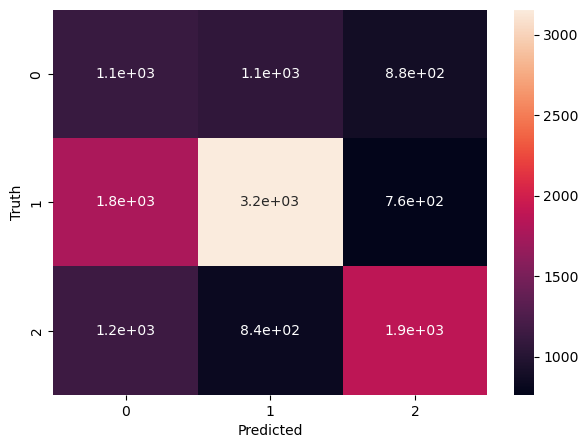

In [150]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Conducting Cross-Fold validation to get the best K value between 1-10

In [151]:
k_range = np.arange(1, 10)

knn = KNeighborsClassifier()

accuracies = []
for k in k_range:
    knn.n_neighbors = k
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

for k, accuracy in zip(k_range, accuracies):
    print('k = {} | Accuracy = {}'.format(k, accuracy))

k = 1 | Accuracy = 0.46532456209875567
k = 2 | Accuracy = 0.42284219703574544
k = 3 | Accuracy = 0.4873583260680035
k = 4 | Accuracy = 0.48458429103590395
k = 5 | Accuracy = 0.5123246413568994
k = 6 | Accuracy = 0.5126416739319966
k = 7 | Accuracy = 0.51715938812713
k = 8 | Accuracy = 0.5239755884917175
k = 9 | Accuracy = 0.5352302449076642


In [159]:
param_grid = {'n_neighbors': np.arange(5, 200, 3)}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print('The best value of K is:',best_k ,'Accuracy:', accuracy)

The best value of K is: 182 Accuracy: 0.5834191963224221


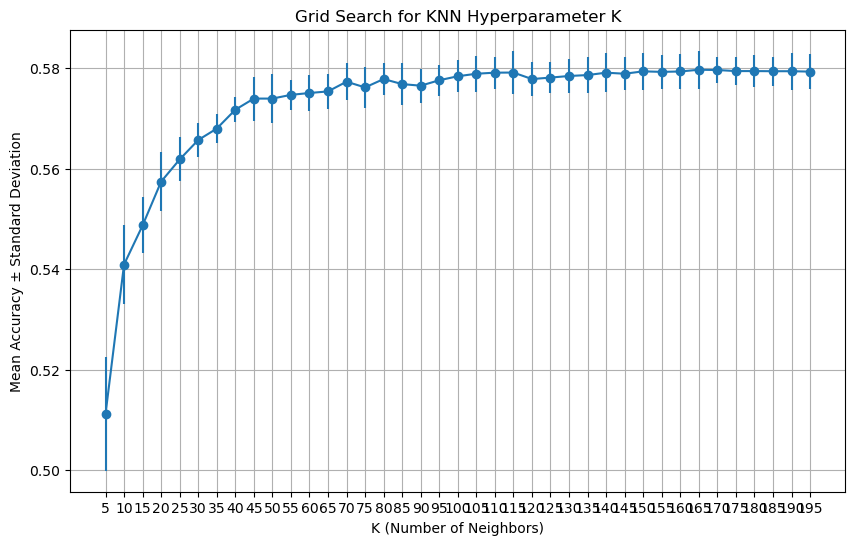

In [160]:
k_values = np.arange(5, 200, 5)  

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': k_values}

cv = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train) 

mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, marker='o', linestyle='-')
plt.title('Grid Search for KNN Hyperparameter K')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Accuracy ± Standard Deviation')
plt.grid(True)
plt.xticks(k_values)
plt.show()

From the above diagram it can be seen that K = 182 has one of the highest accuracies

In [161]:
X_train, X_test, y_train, y_test = train_test_split(corrf, df.Outcome, test_size=0.25)
knn = KNeighborsClassifier(n_neighbors=182)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Plotting a heatmap of the confusion matrix to check how accurately our model has classified the outcome when K = 182

Text(58.222222222222214, 0.5, 'Truth')

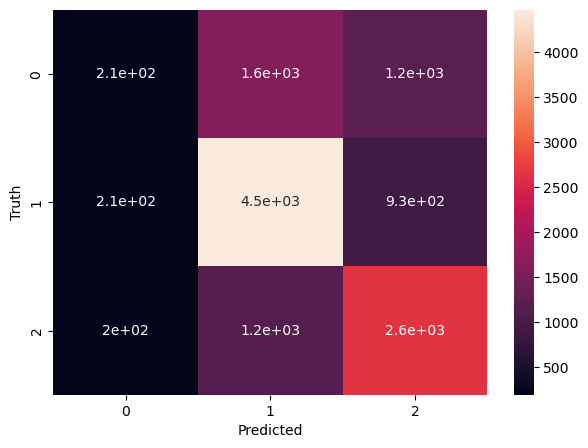

In [162]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')